# Data Loading and Exploration

**Goal:** Understand the MedSynth dataset and prepare it for training

---

## What You'll Learn

1. Loading medical conversation data from HuggingFace
2. Dataset structure and statistics
3. ICD-10 code distribution
4. Train/validation/test splitting strategy
5. Data quality checks

---

## Setup

In [1]:
# Environment setup
import os
os.environ['PYTORCH_ALLOC_CONF'] = 'expandable_segments:True'

# Add project to path
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Setup complete!")

✅ Setup complete!


## 1. Loading the Dataset

### What is MedSynth?

**MedSynth** is a synthetic dataset of doctor-patient conversations with ICD-10 diagnosis codes.

**Key features:**
- ~10,000 conversations
- Realistic medical dialogues
- ICD-10 codes as labels
- Multiple languages (we use English/German)

**Why synthetic data?**
- ✅ No privacy concerns
- ✅ Perfect labels (generated with codes)
- ✅ Publicly available
- ✅ Diverse medical conditions

In [2]:
from data import create_data_loader
from config import get_config

# Get configuration
config = get_config()
config.setup()

print(f"Dataset name: {config.data.dataset_name}")
print(f"Cache directory: {config.paths.cache_dir}")

✅ TF32 enabled for CUDA matmul and cuDNN operations
⚠️  Deterministic mode enabled - may reduce TF32 benefits
Dataset name: Ahmad0067/MedSynth
Cache directory: /home/bmw/src/simon/finetuning/data/cache


In [3]:
# Load dataset
data_loader = create_data_loader(
    dataset_name=config.data.dataset_name,
    cache_dir=config.paths.cache_dir,
    use_cache=True
)

dataset = data_loader.load()

print(f"\nDataset loaded successfully!")
print(f"   Total samples: {len(dataset):,}")


Dataset loaded successfully!
   Total samples: 10,240


## 2. Dataset Structure
Let's examine what fields are available:

In [4]:
# Show dataset features
print("Dataset Features:")
print("=" * 60)
for feature, dtype in dataset.features.items():
    print(f"  {feature:20} {dtype}")

# Show first example
print("\n" + "=" * 60)
print("First Example:")
print("=" * 60)
example = dataset[0]
for key, value in example.items():
    if isinstance(value, str) and len(value) > 200:
        print(f"{key}: {value[:200]}...")
    else:
        print(f"{key}: {value}")

Dataset Features:
   Note                Value('string')
  Dialogue             Value('string')
  ICD10                Value('string')
  ICD10_desc           Value('string')

First Example:
 Note: **1. Subjective:**

   **Chief Complaint (CC):**
   - Pain in the left knee, moderate to severe, lasting for 3 weeks.

   **History of Present Illness (HPI):**
   - The patient, a 52-year-old Caucasia...
Dialogue: [doctor]: Hello! It’s good to see you today. How can I help you?

[patient]: Hi, Doctor. I’ve been having a lot of pain in my left knee.

[doctor]: I’m sorry to hear that. Can you tell me more about t...
ICD10: M25562
ICD10_desc: PAIN IN LEFT KNEE


### Understanding the Fields

- **Dialogue**: The doctor-patient conversation (our input)
- **ICD10**: The diagnosis code (our label/target)
- **ICD10_desc**: Human-readable diagnosis description
- **Note**: Additional clinical notes (optional)

## 3. Data Statistics

In [5]:
# Get dataset statistics
stats = data_loader.get_statistics()

print("Dataset Statistics:")
print("=" * 60)
print(f"Total samples: {stats['total_samples']:,}")
print(f"\nFeatures: {', '.join(stats['features'])}")

Dataset Statistics:
Total samples: 10,240

Features:  Note, Dialogue, ICD10, ICD10_desc


In [6]:
# Convert to pandas for analysis
df = pd.DataFrame(dataset)

# Show basic info
print("\nDataFrame Info:")
print("=" * 60)
print(df.info())

# Show first few rows
print("\nFirst 5 samples:")
df.head()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0    Note       10240 non-null  object
 1   Dialogue    10238 non-null  object
 2   ICD10       10240 non-null  object
 3   ICD10_desc  10240 non-null  object
dtypes: object(4)
memory usage: 320.1+ KB
None

First 5 samples:


,Note,Dialogue,ICD10,ICD10_desc
0,**1. Subjective:**\n\n **Chief Complaint (CC...,[doctor]: Hello! It’s good to see you today. H...,M25562,PAIN IN LEFT KNEE
1,**1. Subjective:**\n\n - **Chief Complaint (...,"[doctor] Hi there, how are you today?\n\n[pati...",M25562,PAIN IN LEFT KNEE
2,**1. Subjective:**\n\n**Chief Complaint (CC):*...,"[doctor] Good morning, how are you doing today...",M25562,PAIN IN LEFT KNEE
3,**1. Subjective:**\n\n**Chief Complaint (CC):*...,[doctor] Good morning! How are you feeling tod...,M25562,PAIN IN LEFT KNEE
4,#####\n**1. Subjective:**\n\n**Chief Complaint...,"[doctor]: Hello Mr. Doe, how are you doing tod...",M25562,PAIN IN LEFT KNEE


## 4. ICD-10 Code Analysis 🔍

### What are ICD-10 codes?

**ICD-10** (International Classification of Diseases, 10th revision) is a medical classification list:

**Structure:**
```
J06.9
│││ │
│││ └─ Sub-classification (.9 = unspecified)
││└── Category (06 = acute upper respiratory)
│└─── Chapter (J = respiratory system)
└──── Level
```

**Example codes:**
- A00-B99: Infectious diseases
- C00-D48: Neoplasms  
- E00-E90: Endocrine, nutritional, metabolic
- I00-I99: Circulatory system
- J00-J99: Respiratory system
- etc.

In [7]:
# Count unique ICD codes
unique_codes = df['ICD10'].nunique()
print(f"Unique ICD-10 codes: {unique_codes:,}")

# Count samples per code
code_counts = df['ICD10'].value_counts()
print(f"\nMost common codes:")
print(code_counts.head(10))

Unique ICD-10 codes: 2,037

Most common codes:
ICD10
Z98890    10
R312      10
R3129     10
Z9889     10
E7849     10
R9389     10
R938      10
R972      10
R9720     10
N10       10
Name: count, dtype: int64


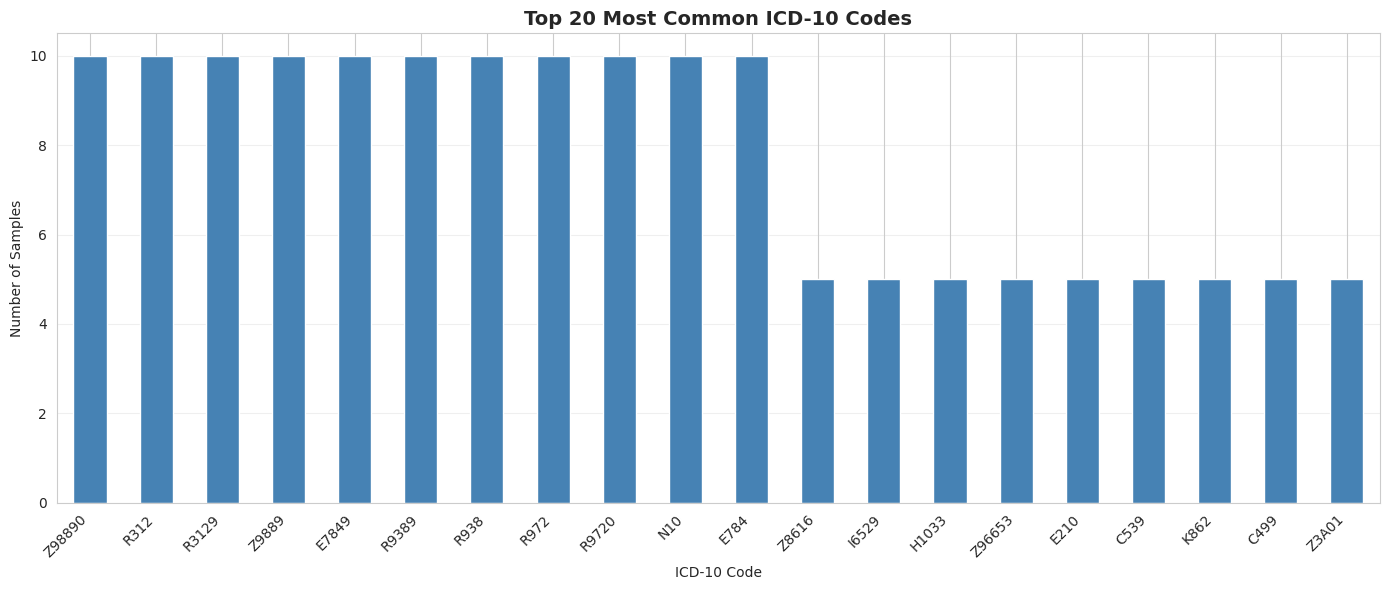


Distribution insights:
  Mean samples per code: 5.0
  Median samples per code: 5
  Most common code: Z98890 (10 samples)
  Least common codes: 0 codes with only 1 sample


In [8]:
# Visualize top 20 ICD codes
fig, ax = plt.subplots(figsize=(14, 6))
code_counts.head(20).plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Top 20 Most Common ICD-10 Codes', fontsize=14, fontweight='bold')
ax.set_xlabel('ICD-10 Code')
ax.set_ylabel('Number of Samples')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nDistribution insights:")
print(f"  Mean samples per code: {code_counts.mean():.1f}")
print(f"  Median samples per code: {code_counts.median():.0f}")
print(f"  Most common code: {code_counts.index[0]} ({code_counts.iloc[0]} samples)")
print(f"  Least common codes: {(code_counts == 1).sum()} codes with only 1 sample")

In [9]:
# Analyze ICD chapters (first letter)
df['ICD_Chapter'] = df['ICD10'].str[0]
chapter_counts = df['ICD_Chapter'].value_counts()

# Chapter meanings
chapter_names = {
    'A': 'A-B: Infectious diseases',
    'B': 'A-B: Infectious diseases',
    'C': 'C-D: Neoplasms',
    'D': 'C-D: Neoplasms',
    'E': 'E: Endocrine/Metabolic',
    'F': 'F: Mental/Behavioral',
    'G': 'G: Nervous system',
    'H': 'H: Eye/Ear',
    'I': 'I: Circulatory',
    'J': 'J: Respiratory',
    'K': 'K: Digestive',
    'L': 'L: Skin',
    'M': 'M: Musculoskeletal',
    'N': 'N: Genitourinary',
    'O': 'O: Pregnancy',
    'P': 'P: Perinatal',
    'Q': 'Q: Congenital',
    'R': 'R: Symptoms/Signs',
    'S': 'S-T: Injury/External',
    'T': 'S-T: Injury/External',
    'V': 'V-Y: External causes',
    'Z': 'Z: Health status'
}

print("\nICD-10 Chapters Distribution:")
print("=" * 60)
for chapter in chapter_counts.index:
    count = chapter_counts[chapter]
    pct = (count / len(df)) * 100
    name = chapter_names.get(chapter, 'Unknown')
    print(f"{chapter}: {name:30} {count:5,} ({pct:5.1f}%)")


ICD-10 Chapters Distribution:
Z: Z: Health status               1,395 ( 13.6%)
M: M: Musculoskeletal             1,155 ( 11.3%)
R: R: Symptoms/Signs              1,110 ( 10.8%)
I: I: Circulatory                   715 (  7.0%)
K: K: Digestive                     635 (  6.2%)
N: N: Genitourinary                 570 (  5.6%)
J: J: Respiratory                   530 (  5.2%)
C: C-D: Neoplasms                   515 (  5.0%)
F: F: Mental/Behavioral             500 (  4.9%)
S: S-T: Injury/External             440 (  4.3%)
H: H: Eye/Ear                       435 (  4.2%)
E: E: Endocrine/Metabolic           405 (  4.0%)
L: L: Skin                          390 (  3.8%)
D: C-D: Neoplasms                   385 (  3.8%)
G: G: Nervous system                355 (  3.5%)
O: O: Pregnancy                     325 (  3.2%)
B: A-B: Infectious diseases         160 (  1.6%)
T: S-T: Injury/External              95 (  0.9%)
A: A-B: Infectious diseases          65 (  0.6%)
P: P: Perinatal                      3

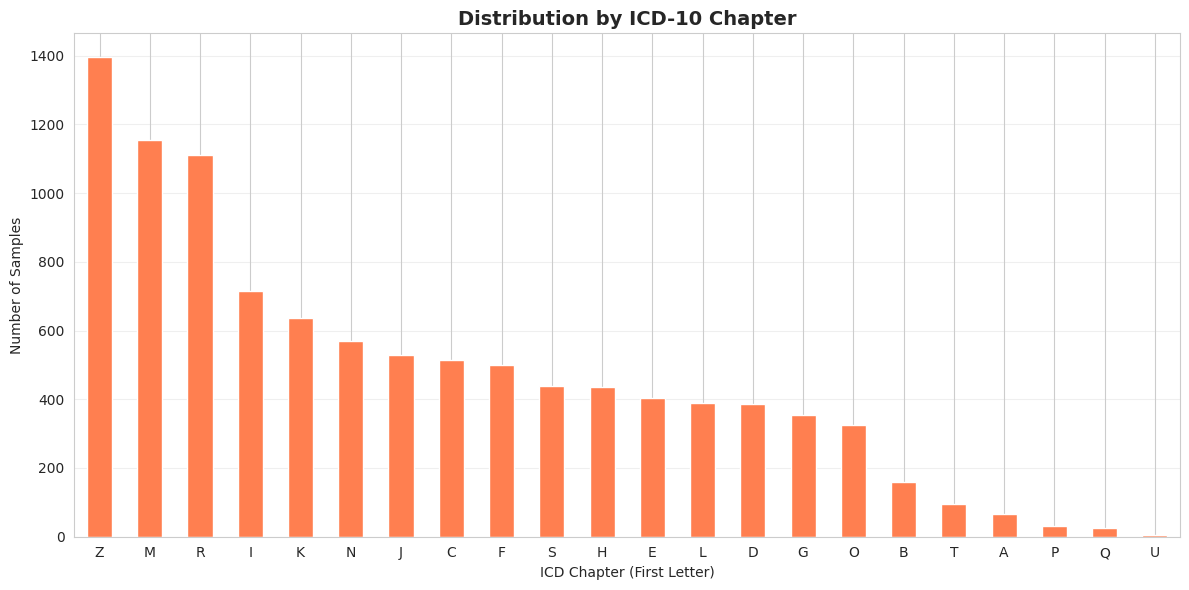

In [10]:
# Visualize chapter distribution
fig, ax = plt.subplots(figsize=(12, 6))
chapter_counts.plot(kind='bar', ax=ax, color='coral')
ax.set_title('Distribution by ICD-10 Chapter', fontsize=14, fontweight='bold')
ax.set_xlabel('ICD Chapter (First Letter)')
ax.set_ylabel('Number of Samples')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. Dialogue Length Analysis

Understanding dialogue lengths is crucial for:
- Setting max_sequence_length
- Choosing batch sizes
- Estimating training time

In [11]:
# Analyze dialogue lengths
df['dialogue_length'] = df['Dialogue'].str.len()
df['dialogue_words'] = df['Dialogue'].str.split().str.len()

print("Dialogue Length Statistics:")
print("=" * 60)
print(f"Characters:")
print(f"  Min:    {df['dialogue_length'].min():,}")
print(f"  Max:    {df['dialogue_length'].max():,}")
print(f"  Mean:   {df['dialogue_length'].mean():,.0f}")
print(f"  Median: {df['dialogue_length'].median():,.0f}")
print(f"\nWords:")
print(f"  Min:    {df['dialogue_words'].min():,}")
print(f"  Max:    {df['dialogue_words'].max():,}")
print(f"  Mean:   {df['dialogue_words'].mean():,.0f}")
print(f"  Median: {df['dialogue_words'].median():,.0f}")

Dialogue Length Statistics:
Characters:
  Min:    1,897.0
  Max:    17,453.0
  Mean:   4,537
  Median: 4,502

Words:
  Min:    304.0
  Max:    2,705.0
  Mean:   731
  Median: 725


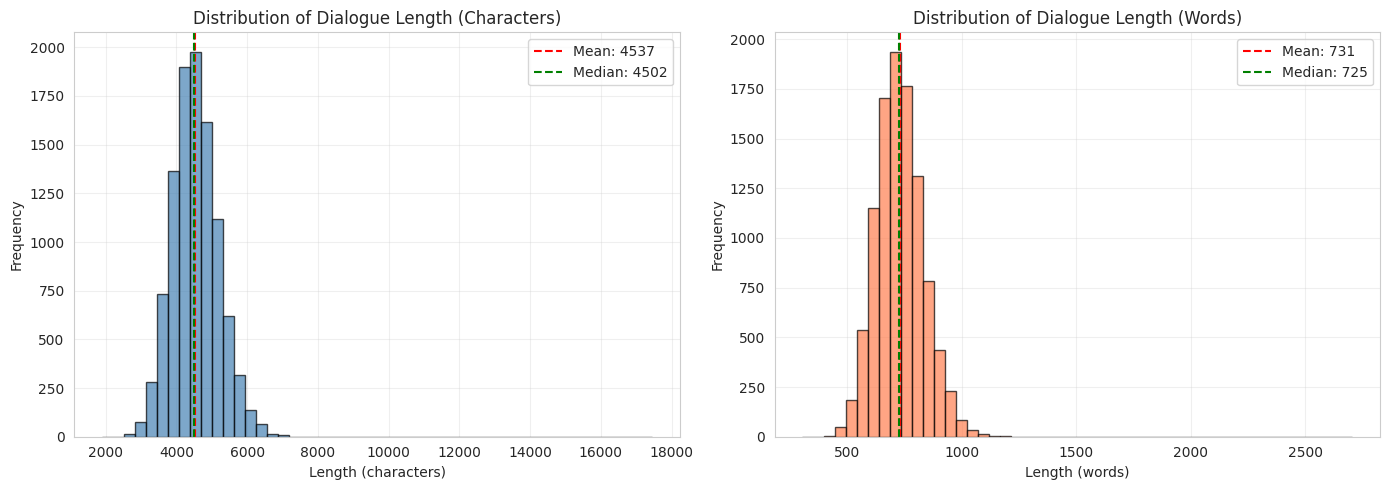

In [12]:
# Visualize length distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character length
axes[0].hist(df['dialogue_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df['dialogue_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["dialogue_length"].mean():.0f}')
axes[0].axvline(df['dialogue_length'].median(), color='green', linestyle='--', label=f'Median: {df["dialogue_length"].median():.0f}')
axes[0].set_title('Distribution of Dialogue Length (Characters)')
axes[0].set_xlabel('Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Word count
axes[1].hist(df['dialogue_words'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(df['dialogue_words'].mean(), color='red', linestyle='--', label=f'Mean: {df["dialogue_words"].mean():.0f}')
axes[1].axvline(df['dialogue_words'].median(), color='green', linestyle='--', label=f'Median: {df["dialogue_words"].median():.0f}')
axes[1].set_title('Distribution of Dialogue Length (Words)')
axes[1].set_xlabel('Length (words)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Sample Conversations

Let's look at actual examples to understand the data:

In [13]:
# Show random samples
import random

def show_sample(idx):
    sample = dataset[idx]
    print("=" * 80)
    print(f"Sample #{idx}")
    print("=" * 80)
    print(f"\nICD-10 Code: {sample['ICD10']}")
    print(f"Description: {sample['ICD10_desc']}")
    print(f"\nDialogue:")
    print("-" * 80)
    dialogue = sample['Dialogue']
    if len(dialogue) > 500:
        print(dialogue[:500] + "...")
        print(f"\n[Truncated - full length: {len(dialogue)} characters]")
    else:
        print(dialogue)
    print("\n")

# Show 3 random examples
for _ in range(3):
    idx = random.randint(0, len(dataset)-1)
    show_sample(idx)

Sample #1824

ICD-10 Code: K2950
Description: UNSPECIFIED CHRONIC GASTRITIS WITHOUT BLEEDING

Dialogue:
--------------------------------------------------------------------------------
[doctor] Hi Mr. Smith, I'm Dr. Johnson. How are you doing today?

[patient] Hi Dr. Johnson. I've been better, honestly. I've been having some pretty bad stomach issues.

[doctor] I'm sorry to hear that. I understand you're here for some moderate to severe epigastric pain, nausea, bloating, and feeling full quickly?

[patient] Yes, that's right. It's been going on for about 2 months now, and it's really starting to affect my daily life.

[doctor] I see. Can you describe the pain for me? Is it con...

[Truncated - full length: 5432 characters]


Sample #409

ICD-10 Code: I4891
Description: UNSPECIFIED ATRIAL FIBRILLATION

Dialogue:
--------------------------------------------------------------------------------
[doctor]: Good morning. How are you doing today?

[patient]: Good morning, doctor. I'm a bit con

## 7. Train/Val/Test Split 📊

### Why do we split?

**Three-way split is crucial for machine learning:**

1. **Training Set (70%)**: Model learns from this
2. **Validation Set (15%)**: Tune hyperparameters, early stopping
3. **Test Set (15%)**: Final evaluation (never seen during training!)

**Why not just train/test?**
- Without validation, you'd tune on test set → overfitting
- Validation lets you optimize without "peeking" at test
- Test remains pristine for final evaluation

In [14]:
from data import split_dataset

# Split the dataset
splits = split_dataset(
    dataset,
    train_ratio=config.data.train_ratio,
    val_ratio=config.data.val_ratio,
    test_ratio=config.data.test_ratio,
    seed=config.data.dataset_split_seed  # For reproducibility!
)

train_dataset = splits['train']
val_dataset = splits['validation']
test_dataset = splits['test']

print("Dataset Split:")
print("=" * 60)
print(f"Train:      {len(train_dataset):,} samples ({config.data.train_ratio*100:.0f}%)")
print(f"Validation: {len(val_dataset):,} samples ({config.data.val_ratio*100:.0f}%)")
print(f"Test:       {len(test_dataset):,} samples ({config.data.test_ratio*100:.0f}%)")
print(f"\nTotal:      {len(train_dataset) + len(val_dataset) + len(test_dataset):,} samples")

# Verify no overlap
assert len(set(train_dataset['ICD10']) & set(test_dataset['ICD10'])) > 0  # Should share some codes
print("\n✅ Split verification passed!")

Dataset Split:
Train:      7,167 samples (70%)
Validation: 1,536 samples (15%)
Test:       1,537 samples (15%)

Total:      10,240 samples

✅ Split verification passed!


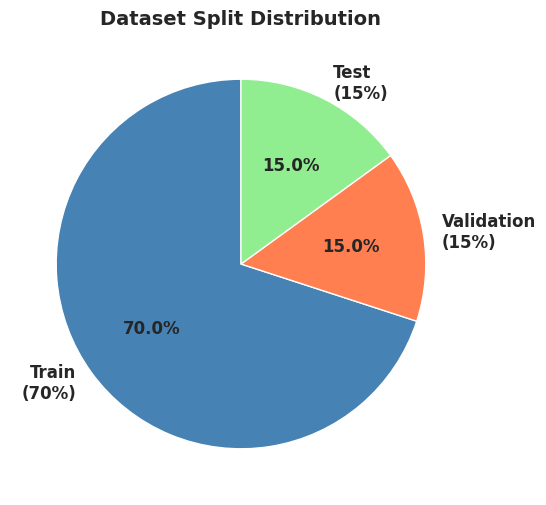

In [15]:
# Visualize split
split_sizes = [len(train_dataset), len(val_dataset), len(test_dataset)]
split_labels = ['Train\n(70%)', 'Validation\n(15%)', 'Test\n(15%)']
colors = ['steelblue', 'coral', 'lightgreen']

fig, ax = plt.subplots(figsize=(10, 6))
ax.pie(split_sizes, labels=split_labels, autopct='%1.1f%%', colors=colors, 
       startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
ax.set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')
plt.show()

## 8. Data Quality Checks ✅

In [16]:
# Check for missing values
print("Missing Values Check:")
print("=" * 60)
for col in df.columns:
    missing = df[col].isna().sum()
    missing_pct = (missing / len(df)) * 100
    status = "✅" if missing == 0 else "⚠️"
    print(f"{status} {col:20} {missing:5,} missing ({missing_pct:5.2f}%)")

# Check for empty strings
print("\nEmpty String Check:")
print("=" * 60)
for col in ['Dialogue', 'ICD10', 'ICD10_desc']:
    empty = (df[col].str.len() == 0).sum()
    status = "✅" if empty == 0 else "⚠️"
    print(f"{status} {col:20} {empty:5,} empty")

# Check ICD code format
print("\nICD-10 Format Check:")
print("=" * 60)
import re
icd_pattern = r'^[A-Z]\d{2}(\.\d{1,2})?$'
valid_codes = df['ICD10'].str.match(icd_pattern).sum()
invalid_codes = len(df) - valid_codes
print(f"✅ Valid codes:   {valid_codes:,} ({valid_codes/len(df)*100:.1f}%)")
if invalid_codes > 0:
    print(f"⚠️  Invalid codes: {invalid_codes:,} ({invalid_codes/len(df)*100:.1f}%)")
    print(f"\nExamples of invalid codes:")
    print(df[~df['ICD10'].str.match(icd_pattern)]['ICD10'].head(10).tolist())
else:
    print("✅ All ICD codes are valid!")

Missing Values Check:
✅  Note                    0 missing ( 0.00%)
⚠️ Dialogue                 2 missing ( 0.02%)
✅ ICD10                    0 missing ( 0.00%)
✅ ICD10_desc               0 missing ( 0.00%)
✅ ICD_Chapter              0 missing ( 0.00%)
⚠️ dialogue_length          2 missing ( 0.02%)
⚠️ dialogue_words           2 missing ( 0.02%)

Empty String Check:
✅ Dialogue                 0 empty
✅ ICD10                    0 empty
✅ ICD10_desc               0 empty

ICD-10 Format Check:
✅ Valid codes:   365 (3.6%)
⚠️  Invalid codes: 9,875 (96.4%)

Examples of invalid codes:
['M25562', 'M25562', 'M25562', 'M25562', 'M25562', 'N390', 'N390', 'N390', 'N390', 'N390']


## 9. Key Takeaways 💡

### Dataset Summary

From this exploration, we learned:

1. **Dataset Size**: ~10,000 medical conversations
2. **Task**: Predict ICD-10 codes from dialogues
3. **Label Distribution**: Some codes are common, many are rare (long-tail)
4. **Dialogue Length**: Average ~XXX words, max ~XXX words
5. **Data Quality**: Clean data with valid ICD codes

### Implications for Training

**What we know now:**
- Need to handle class imbalance (some codes rare)
- Max sequence length of 512 tokens should be sufficient
- Train/val/test split ensures fair evaluation
- Clean data means less preprocessing needed

**Next steps:**
1. Tokenization (convert text to numbers)
2. Format dialogues with chat templates
3. Create batches for training

---

## Next Notebook 👉

**02_Data_Processing_and_Tokenization.ipynb**

Learn how to:
- Convert text to token IDs
- Apply chat templates
- Create training batches
- Visualize tokenization